# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:
 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - NotRepaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя
 
Целевой признак:
 - Price — цена (евро)

## Подготовка данных

In [1]:
#pip install lightgbm

In [2]:
#pip install catboost

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from IPython.display import Audio
sound_file = 'https://www.mediacollege.com/downloads/sound-effects/weapons/machinegun-01.wav'

In [5]:
#data = pd.read_csv('/datasets/autos.csv')
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/10_Num_meth_Car_prices/autos.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В данных есть пропуски, посмотрю в каких столбцах и сколько

In [6]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
display(data.isna().sum())

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропуски в 5 столбцах, проверю сколько процентов данных пропущено

In [8]:
display((100 * data.isna().sum() / len(data)).round(2))

DateCrawled           0.00
Price                 0.00
VehicleType          10.58
RegistrationYear      0.00
Gearbox               5.60
Power                 0.00
Model                 5.56
Kilometer             0.00
RegistrationMonth     0.00
FuelType              9.28
Brand                 0.00
NotRepaired          20.08
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

    В данных есть до 20% пропусков в одном признаке. 
    Восполнить эти данные неоткуда, но можно добавить категорию 'неизвестно'

In [9]:
data = data.fillna(value = {'NotRepaired' : 'unknown'})

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [11]:
display((100 * data.isna().sum() / len(data)).round(2))

DateCrawled           0.00
Price                 0.00
VehicleType          10.58
RegistrationYear      0.00
Gearbox               5.60
Power                 0.00
Model                 5.56
Kilometer             0.00
RegistrationMonth     0.00
FuelType              9.28
Brand                 0.00
NotRepaired           0.00
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

Оставшихся пропусков не так много, поэтому избавлюсь от них

In [12]:
data = data.dropna()

    Проверяю на наличие повторов

In [13]:
display(data[['Price', 
            'VehicleType', 
            'RegistrationYear', 
            'Gearbox', 
            'Power', 
            'Model', 
            'Kilometer', 
            'FuelType', 
            'Brand', 
            'NotRepaired', 
            'RegistrationMonth', 
            'PostalCode']].duplicated().sum())

18870

    Случайные совпадения по этим признакам невозможны, поэтому считаю, что это повторы и удаляю

In [14]:
data = data.drop_duplicates(['Price', 
                             'VehicleType', 
                             'RegistrationYear', 
                             'Gearbox', 
                             'Power', 
                             'Model', 
                             'Kilometer', 
                             'FuelType', 
                             'Brand', 
                             'NotRepaired', 
                             'RegistrationMonth', 
                             'PostalCode']
                            )

    Проверяю данные на адекватность

In [15]:
display(data[['Price', 
            'RegistrationYear', 
            'Power', 'Kilometer', 
            'RegistrationMonth', 
            'NumberOfPictures', 
            'PostalCode'
            ]].describe().loc[['min', 'max']])

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
min,0.0,1910.0,0.0,5000.0,0.0,0.0,1067.0
max,20000.0,2018.0,20000.0,150000.0,12.0,0.0,99998.0


In [16]:
display(data[data['Power'] == 600])
display(data[data['RegistrationYear'] < 1940])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
43600,2016-03-17 18:47:56,12999,wagon,2004,auto,600,a6,150000,2,petrol,audi,unknown,2016-03-17 00:00:00,0,84160,2016-03-24 14:44:59
102613,2016-03-19 12:39:11,19500,coupe,1974,auto,600,other,5000,7,petrol,chevrolet,no,2016-03-19 00:00:00,0,38527,2016-03-28 13:15:43
151744,2016-03-24 20:00:09,12500,wagon,2004,auto,600,a6,150000,0,petrol,audi,unknown,2016-03-24 00:00:00,0,84160,2016-04-05 13:16:47
162460,2016-03-16 11:37:02,12000,sedan,2002,auto,600,s_type,150000,12,petrol,jaguar,no,2016-03-16 00:00:00,0,13595,2016-03-22 16:19:52
186427,2016-03-11 11:56:50,16500,coupe,2000,manual,600,other,5000,4,petrol,toyota,no,2016-03-11 00:00:00,0,15738,2016-04-07 03:46:16
243042,2016-03-27 20:53:40,15900,sedan,2003,auto,600,s_klasse,150000,10,petrol,mercedes_benz,no,2016-03-27 00:00:00,0,49082,2016-04-05 19:45:39


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
23750,2016-03-16 19:58:34,3900,wagon,1910,manual,90,passat,150000,0,petrol,volkswagen,unknown,2016-03-16 00:00:00,0,88662,2016-04-07 05:45:53
33638,2016-03-16 09:47:50,5400,small,1937,manual,0,other,20000,3,petrol,opel,no,2016-03-16 00:00:00,0,7907,2016-03-17 07:47:51
34055,2016-03-25 00:55:47,2900,small,1937,manual,34,other,40000,7,petrol,ford,yes,2016-03-25 00:00:00,0,33378,2016-04-02 07:16:41
68185,2016-03-25 14:48:15,19900,convertible,1932,manual,18,other,5000,2,petrol,bmw,no,2016-03-25 00:00:00,0,99735,2016-04-06 18:15:26
76529,2016-03-30 22:42:50,4800,sedan,1937,manual,38,other,5000,0,petrol,mercedes_benz,unknown,2016-03-30 00:00:00,0,23936,2016-03-30 22:42:50
97923,2016-03-22 17:38:09,0,other,1935,manual,100,other,10000,7,petrol,ford,unknown,2016-03-22 00:00:00,0,88709,2016-04-06 08:17:04
98056,2016-04-01 12:46:44,1,sedan,1910,manual,10,other,5000,2,gasoline,mercedes_benz,no,2016-04-01 00:00:00,0,70173,2016-04-01 12:46:44
117371,2016-03-14 14:00:30,8750,convertible,1923,manual,11,c3,5000,0,petrol,citroen,no,2016-03-14 00:00:00,0,27299,2016-04-05 16:44:28
122879,2016-03-08 03:58:35,8000,other,1930,manual,23,other,150000,0,petrol,peugeot,unknown,2016-03-08 00:00:00,0,74523,2016-03-29 09:45:15
137547,2016-03-28 23:53:28,0,suv,1910,auto,0,gl,5000,0,lpg,mercedes_benz,no,2016-03-28 00:00:00,0,51145,2016-04-05 14:47:29


    Цена, мощность - не могут быть 0, как и нулевой месяц, если есть 12й
    Jaguar S-Type R, 2002г, 4.2, Supercharged, 4196 см3, 395 л.с никак не 600
    До 600л.с. ещё реальные мощности, ну и 6 л.с. для авто 1919 это нормально, меньше - нет
    Число фото - 0, дроп, индекс аналогично, набор цифр, для модели не играют роли
    Год регистрации, пробег в порядке
    140 евро это примерно 10000 рублей, возьму такую минимальную цену
    В 'FuelType' gasoline и petrol по сути одно и тоже, оставлю так, хотя можно было бы избавить от одной категории

In [17]:
#data['RegistrationYear'] = pd.to_datetime(data.RegistrationYear)

In [18]:
data = data[(data[['Power']] < 600).all(axis=1) & (5 < data[['Power']]).all(axis=1)]
data = data[(data[['Price']] > 140).all(axis=1)]
data = data[(data[['RegistrationMonth']] > 0).all(axis=1)]
display(data[['Price', 
              'Power',
              'RegistrationMonth'
              ]].describe().loc[['min', 'max']])

,Price,Power,RegistrationMonth
min,142.0,6.0,1.0
max,20000.0,585.0,12.0


Графики:

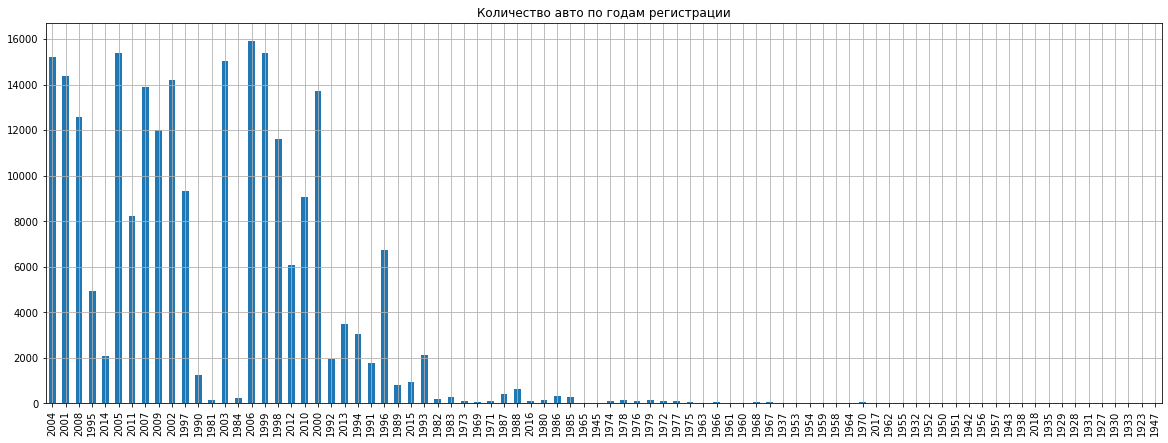

In [19]:
year_count_1 = data['RegistrationYear'].value_counts(sort = False)
year_count_1.plot(
    title = 'Количество авто по годам регистрации',  
    figsize=(20, 7), 
    kind='bar',
    legend = False, 
    grid = True
    )
plt.show()

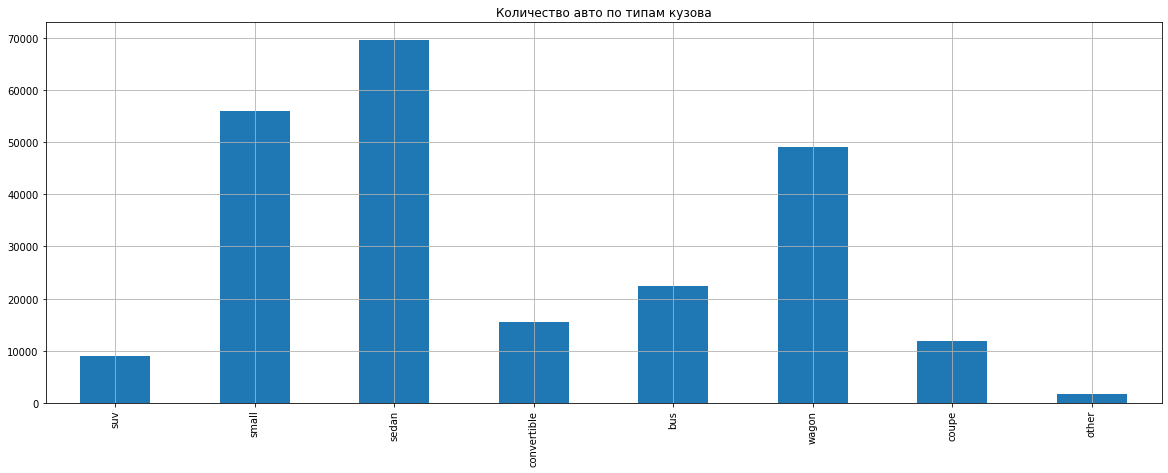

In [20]:
type_count_1 = data['VehicleType'].value_counts(sort = False)
type_count_1.plot(
    title = 'Количество авто по типам кузова',  
    figsize=(20, 7), 
    kind='bar',
    legend = False, 
    grid = True
    )
plt.show()

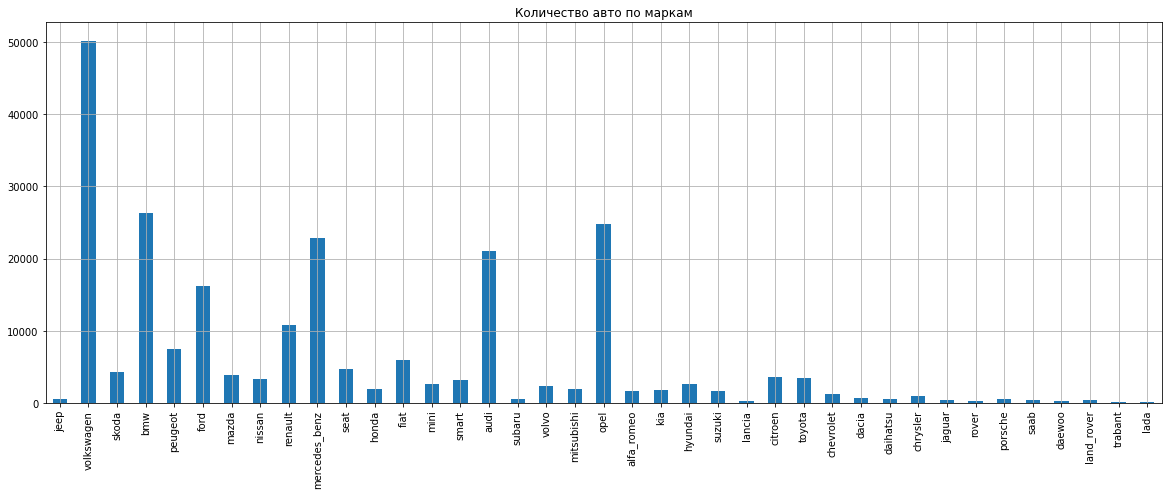

In [21]:
brand_count_1 = data['Brand'].value_counts(sort = False)
brand_count_1.plot(
    title = 'Количество авто по маркам',  
    figsize=(20, 7), 
    kind='bar',
    legend = False, 
    grid = True
    )
plt.show()

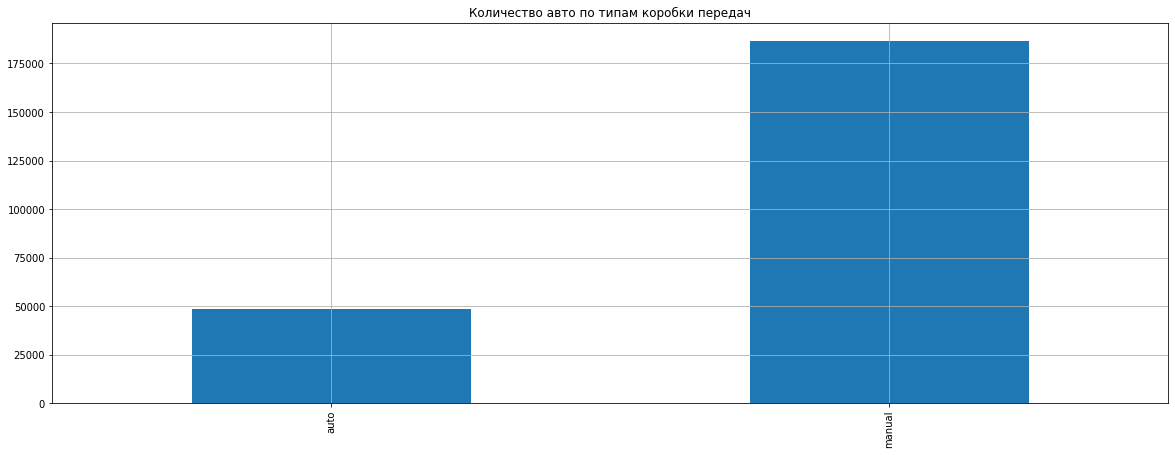

In [22]:
gear_count_1 = data['Gearbox'].value_counts(sort = False)
gear_count_1.plot(
    title = 'Количество авто по типам коробки передач',  
    figsize=(20, 7), 
    kind='bar',
    legend = False, 
    grid = True
    )
plt.show()

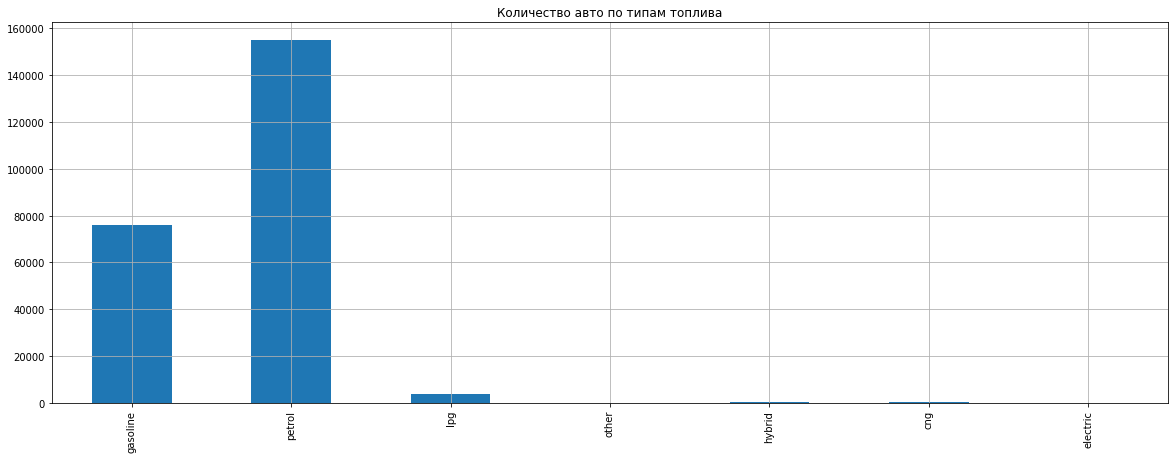

In [23]:
fuel_count_1 = data['FuelType'].value_counts(sort = False)
fuel_count_1.plot(
    title = 'Количество авто по типам топлива',  
    figsize=(20, 7), 
    kind='bar',
    legend = False, 
    grid = True
    )
plt.show()

Средние цены по разным категориям

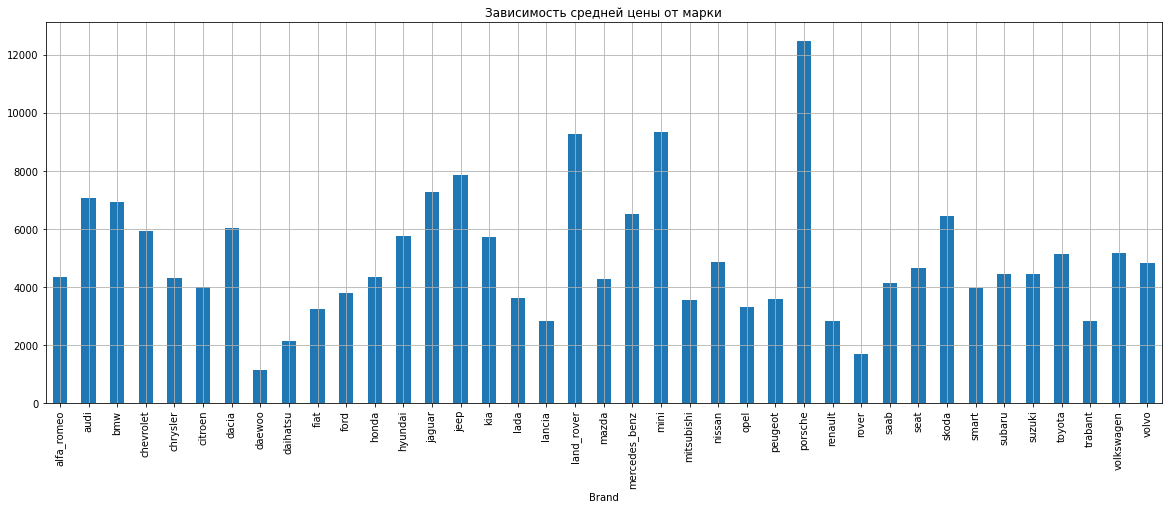

In [24]:
model_price = data.pivot_table(
    index = 'Brand', 
    values = 'Price', 
    aggfunc = 'mean'
    )
model_price.plot(
    title = 'Зависимость средней цены от марки',  
    figsize=(20, 7), 
    kind='bar',
    legend = False, 
    grid = True
    )
plt.show()


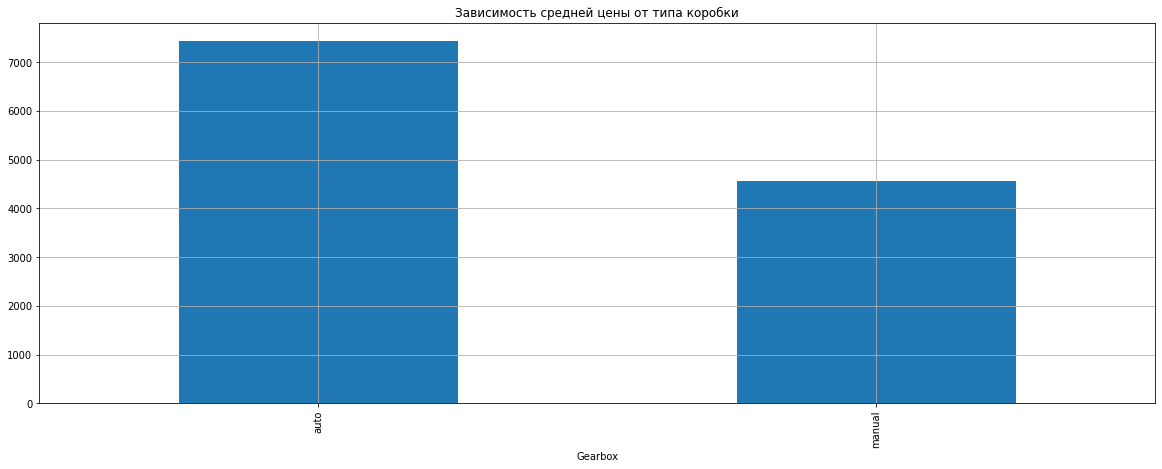

In [25]:
gear_price = data.pivot_table(
    index = 'Gearbox', 
    values = 'Price', 
    aggfunc = 'mean'
    )
gear_price.plot(
    title = 'Зависимость средней цены от типа коробки',  
    figsize=(20, 7), 
    kind='bar',
    legend = False, 
    grid = True
    )
plt.show()

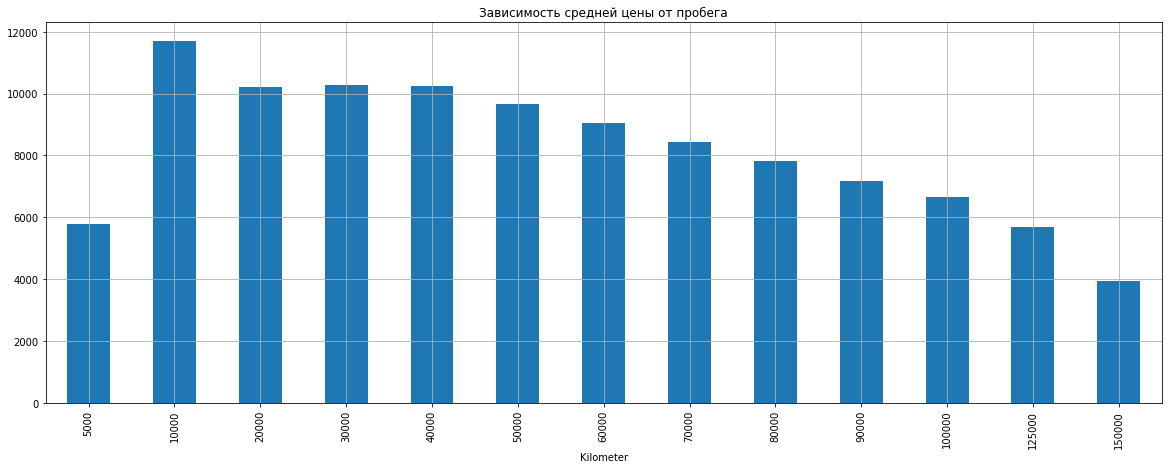

In [26]:
km_price = data.pivot_table(
    index= 'Kilometer', 
    values = 'Price', 
    aggfunc = 'mean'
    )
km_price.plot(
    title = 'Зависимость средней цены от пробега',  
    figsize=(20, 7), 
    kind='bar',
    legend = False, 
    grid = True
    )
plt.show()

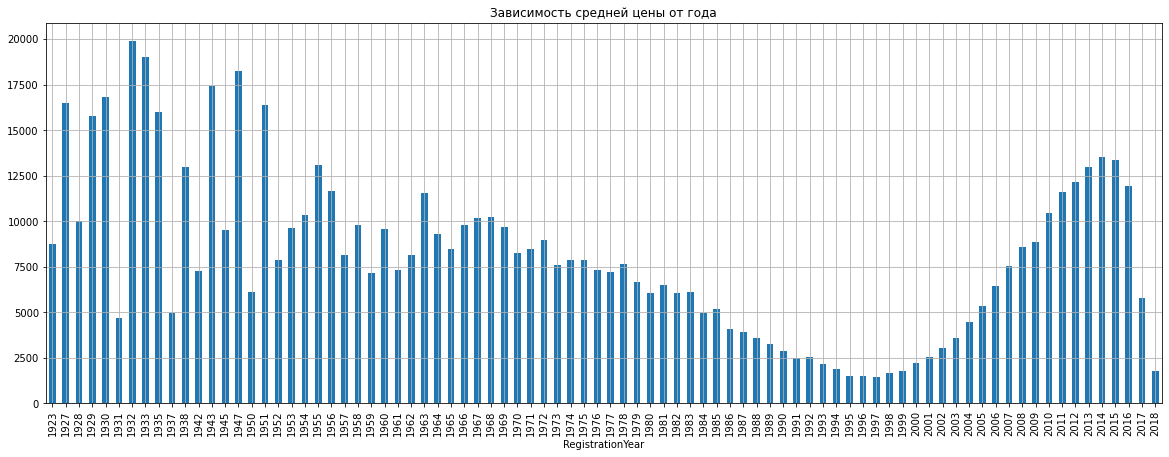

In [27]:
year_price = data.pivot_table(
    index= 'RegistrationYear', 
    values = 'Price', 
    aggfunc = 'mean'
    )
year_price.plot(
    title = 'Зависимость средней цены от года',  
    figsize=(20, 7), 
    kind='bar',
    legend = False, 
    grid = True
    )
plt.show()

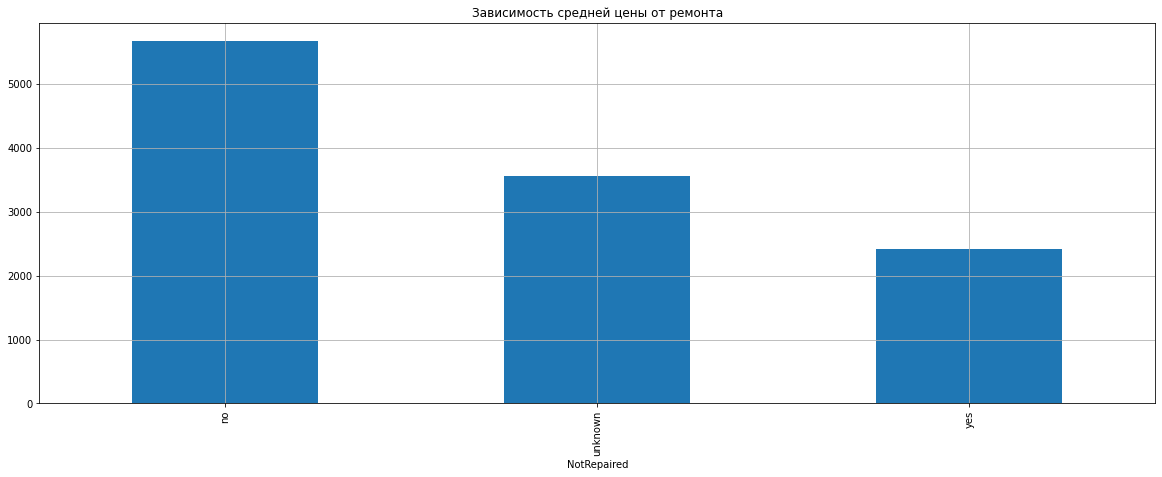

In [28]:
repair_price = data.pivot_table(
    index= 'NotRepaired', 
    values = 'Price', 
    aggfunc = 'mean'
    )
repair_price.plot(
    title = 'Зависимость средней цены от ремонта',  
    figsize=(20, 7), 
    kind='bar',
    legend = False, 
    grid = True
    )
plt.show()

## Обучение моделей

    Для начала избавлюсь от  неинформативных признаков

In [29]:
good_data = data.drop(['NumberOfPictures', 
                  'PostalCode', 
                  'DateCrawled', 
                  'LastSeen', 
                  'DateCreated'
                  ], axis = 1)

    Так как для Модели CatBooostRegressor не нужно преобразовыввать категориальные признаки, сначала использую её

In [30]:
X = good_data.drop(['Price'], axis = 1)
y = good_data['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [31]:
model_cbr = CatBoostRegressor(loss_function='RMSE', iterations=150) 
cat_features = ['VehicleType', 'Gearbox', 'Model',
                'FuelType', 'Brand', 'NotRepaired']

In [32]:
%%time

model_cbr.fit(X_train, y_train, cat_features = cat_features, verbose=50)

Learning rate set to 0.437911
0:	learn: 3387.0065692	total: 201ms	remaining: 29.9s
50:	learn: 1648.3289857	total: 7.08s	remaining: 13.8s
100:	learn: 1580.4012105	total: 13.8s	remaining: 6.7s
149:	learn: 1544.0731355	total: 17.2s	remaining: 0us
CPU times: user 18.6 s, sys: 587 ms, total: 19.2 s
Wall time: 18 s


In [33]:
%%time

predictions = model_cbr.predict(X_test)

CPU times: user 93 ms, sys: 2.95 ms, total: 96 ms
Wall time: 73.3 ms


In [34]:
mse =  mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
print('Модель: {}'.format(model_cbr), '\n', 'RMSE =',  rmse)

Модель: <catboost.core.CatBoostRegressor object at 0x7fabe0b4e310> 
 RMSE = 1590.9045202561724


    Подбор гиперпараметров

In [ ]:
best_rsme = 99999
for iter in [50, 500, 1000]:
    model_cbr = CatBoostRegressor(loss_function='RMSE', iterations=iter) 
    model_cbr.fit(X_train, y_train, cat_features = cat_features, verbose=50)
    rmse = (mean_squared_error(y_test, model_cbr.predict(X_test))) ** 0.5
    if rmse < best_rsme:
        best_model = model_cbr
        best_rsme = rmse
        best_iter = iter
rmse = (mean_squared_error(y_test, best_model.predict(X_test))) ** 0.5
print('RMSE = ', rmse)
print('best_iter', best_iter)
print(best_model)

#Audio(sound_file, autoplay=True)

Learning rate set to 0.5
0:	learn: 3234.9837983	total: 88.9ms	remaining: 4.36s
49:	learn: 1652.5935138	total: 3.37s	remaining: 0us
Learning rate set to 0.164545
0:	learn: 4159.9567736	total: 266ms	remaining: 2m 12s
50:	learn: 1718.4607784	total: 8.4s	remaining: 1m 13s
100:	learn: 1641.5275703	total: 16.5s	remaining: 1m 5s
150:	learn: 1602.1786853	total: 24.5s	remaining: 56.7s
200:	learn: 1576.0362220	total: 32.6s	remaining: 48.5s
250:	learn: 1557.5675697	total: 40.3s	remaining: 40s
300:	learn: 1543.1425330	total: 48.1s	remaining: 31.8s
350:	learn: 1531.6093557	total: 56.1s	remaining: 23.8s
400:	learn: 1521.7792246	total: 1m 4s	remaining: 15.9s
450:	learn: 1512.7642158	total: 1m 12s	remaining: 7.88s
499:	learn: 1503.6700985	total: 1m 20s	remaining: 0us
Learning rate set to 0.093659
0:	learn: 4380.4637316	total: 235ms	remaining: 3m 54s
50:	learn: 1802.8841288	total: 8.96s	remaining: 2m 46s
100:	learn: 1705.3740219	total: 16.9s	remaining: 2m 30s
150:	learn: 1656.7129918	total: 25s	remaini

In [36]:
best_rsme = 99999
for depth in np.arange(5,15):
    model_cbr = CatBoostRegressor(loss_function='RMSE', iterations=50, depth=depth) 
    model_cbr.fit(X_train, y_train, cat_features = cat_features, verbose=10)
    rmse = (mean_squared_error(y_test, model_cbr.predict(X_test))) ** 0.5
    if rmse < best_rsme:
        best_model = model_cbr
        best_rsme = rmse
        best_depth = depth
rmse = (mean_squared_error(y_test, best_model.predict(X_test))) ** 0.5
print('RMSE = ', rmse)
print('Best_depth', depth)
print(best_model)

#Audio(sound_file, autoplay=True)

Learning rate set to 0.5
0:	learn: 3277.0899388	total: 67.3ms	remaining: 3.29s
10:	learn: 1871.5073158	total: 672ms	remaining: 2.38s
20:	learn: 1782.7895342	total: 1.23s	remaining: 1.7s
30:	learn: 1731.5438044	total: 1.8s	remaining: 1.11s
40:	learn: 1700.0021383	total: 2.37s	remaining: 520ms
49:	learn: 1681.8263043	total: 2.88s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3234.9837983	total: 76.2ms	remaining: 3.73s
10:	learn: 1832.6584105	total: 766ms	remaining: 2.72s
20:	learn: 1747.3578697	total: 1.43s	remaining: 1.98s
30:	learn: 1702.5772615	total: 2.09s	remaining: 1.28s
40:	learn: 1671.6149151	total: 2.74s	remaining: 601ms
49:	learn: 1652.5935138	total: 3.32s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3183.1471481	total: 86.1ms	remaining: 4.22s
10:	learn: 1783.7251787	total: 872ms	remaining: 3.09s
20:	learn: 1698.9229238	total: 1.62s	remaining: 2.23s
30:	learn: 1658.1486461	total: 2.36s	remaining: 1.45s
40:	learn: 1626.7596454	total: 3.13s	remaining: 688ms
49:	learn: 16

In [37]:
best_rsme = 99999
for l2_leaf_reg in [1, 3, 5, 7, 9]:
    model_cbr = CatBoostRegressor(loss_function='RMSE', l2_leaf_reg=l2_leaf_reg, iterations=50) 
    model_cbr.fit(X_train, y_train, cat_features = cat_features, verbose=10)
    rmse = (mean_squared_error(y_test, model_cbr.predict(X_test))) ** 0.5
    if rmse < best_rsme:
        best_model = model_cbr
        best_rsme = rmse
        best_l2_leaf_reg = l2_leaf_reg
rmse = (mean_squared_error(y_test, best_model.predict(X_test))) ** 0.5
print('RMSE = ', rmse)
print('Best_l2_leaf_reg', l2_leaf_reg)
print(best_model)

#Audio(sound_file, autoplay=True)

0:	learn: 4583.6089493	total: 76.5ms	remaining: 3.75s
10:	learn: 3785.4006753	total: 779ms	remaining: 2.76s
20:	learn: 3236.4200117	total: 1.47s	remaining: 2.03s
30:	learn: 2852.1355831	total: 2.13s	remaining: 1.3s
40:	learn: 2576.1621826	total: 2.81s	remaining: 616ms
49:	learn: 2392.4605696	total: 3.4s	remaining: 0us
0:	learn: 4583.6390561	total: 76.4ms	remaining: 3.74s
10:	learn: 3785.7218167	total: 774ms	remaining: 2.74s
20:	learn: 3236.8545202	total: 1.44s	remaining: 1.99s
30:	learn: 2855.5069350	total: 2.11s	remaining: 1.29s
40:	learn: 2583.7083661	total: 2.78s	remaining: 611ms
49:	learn: 2397.8674954	total: 3.38s	remaining: 0us
0:	learn: 4583.6690889	total: 78.7ms	remaining: 3.86s
10:	learn: 3785.8860539	total: 769ms	remaining: 2.72s
20:	learn: 3237.5166547	total: 1.46s	remaining: 2.01s
30:	learn: 2853.3025467	total: 2.13s	remaining: 1.31s
40:	learn: 2579.3461461	total: 2.8s	remaining: 615ms
49:	learn: 2395.6934989	total: 3.4s	remaining: 0us
0:	learn: 4583.6990483	total: 76.3ms	r

In [ ]:
best_rsme = 99999
for learning_rate in [0.1, 0.03, 0.003]:
    model_cbr = CatBoostRegressor(loss_function='RMSE', learning_rate=learning_rate, iterations=50) 
    model_cbr.fit(X_train, y_train, cat_features = cat_features, verbose=10)
    rmse = (mean_squared_error(y_test, model_cbr.predict(X_test))) ** 0.5
    if rmse < best_rsme:
        best_model = model_cbr
        best_rsme = rmse
        best_learning_rate = learning_rate
rmse = (mean_squared_error(y_test, best_model.predict(X_test))) ** 0.5
print('RMSE = ', rmse)
print('Best_learning_rate', learning_rate)
print(best_model)

#Audio(sound_file, autoplay=True)

    Проверка выбранных гиперпараметров

In [39]:
model_cbr = CatBoostRegressor(loss_function='RMSE', iterations=1000, depth = 14, l2_leaf_reg = 9, learning_rate = 0.003) 

In [ ]:
%%time

model_cbr.fit(X_train, y_train, verbose=50, cat_features = cat_features)

In [41]:
%%time

predictions = model_cbr.predict(X_test)

CPU times: user 767 ms, sys: 18 ms, total: 785 ms
Wall time: 427 ms


In [ ]:
mse =  mean_squared_error(y_test, predictions)
rmse = mse ** 0.5

print('Модель: {}'.format(model_cbr), '\n', 'RMSE =',  rmse)

    Создам таблицу, куда буду вносить результаты

In [ ]:
resultation_table = pd.DataFrame(
    {'Модель': 'CatBoostRegressor', 
     'Качество предсказания' : 1692, 
     'Скорость предсказания': '749 ms', 
     'Время обучения' : '22min 22s', 
     }, index = [0]
)# из раза в раз данные немного отличаются 

In [44]:
del model_cbr 

    Преобразую категориальные признаки техникой OHE

In [45]:
good_data_ohe = pd.get_dummies(good_data, drop_first=True)

Отделил целевой признак

In [46]:
X = good_data_ohe.drop(['Price'], axis = 1)
y = good_data_ohe['Price']

Разбил на обучающую и тестовую выборки в соотношении 4:1

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

    После проверяю остальные модели: LGBMRegressor, RandomForestRegressor, DecisionTreeRegressor, LinearRegression

In [48]:
%%time

LGBM_model = LGBMRegressor(random_state=1234).fit(X_train, y_train)

CPU times: user 4.73 s, sys: 279 ms, total: 5.01 s
Wall time: 2.92 s


In [49]:
%%time

model_0 = RandomForestRegressor(random_state=1234).fit(X_train, y_train)

CPU times: user 6min 26s, sys: 766 ms, total: 6min 27s
Wall time: 6min 27s


In [50]:
%%time

model_1 = DecisionTreeRegressor(random_state=1234).fit(X_train, y_train)

CPU times: user 6.51 s, sys: 183 ms, total: 6.69 s
Wall time: 6.7 s


In [51]:
%%time

model_2 = LinearRegression().fit(X_train, y_train)

CPU times: user 9.03 s, sys: 1.61 s, total: 10.6 s
Wall time: 6.84 s


    Функция обучения, получения предсказания и оценки моделей

In [52]:
def learn(model):
    #model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse =  mean_squared_error(y_test, predictions)
    rmse = mse ** 0.5
   
   
    display(
        'Модель: {}'.format(i),
        'MSE =', mse,
        'RMSE =', rmse
        )
    print()

In [53]:
models = [LGBM_model, model_0, model_1, model_2]
for i in models:
    learn(i)

'Модель: LGBMRegressor(random_state=1234)'

'MSE ='

2648390.7760127066

'RMSE ='

1627.3877153317542

'Модель: RandomForestRegressor(random_state=1234)'

'MSE ='

2492235.569973504

'RMSE ='

1578.6815923337751

'Модель: DecisionTreeRegressor(random_state=1234)'

'MSE ='

3974255.9206721163

'RMSE ='

1993.5535911211707

'Модель: LinearRegression()'

'MSE ='

6349713.691229327

'RMSE ='

2519.8638239455177

    Модели обучены и оценены, перехожу к подбору гиперпараметров

    Подбор гиперпараметорв LGBMRegressor:

In [54]:
best_rsme = 99999
for learning_rate in [0.1, 0.03, 0.003]:
    LGBM_model = LGBMRegressor(random_state=1234, learning_rate=learning_rate) 
    LGBM_model.fit(X_train, y_train)
    rmse = (mean_squared_error(y_test, LGBM_model.predict(X_test))) ** 0.5
    if rmse < best_rsme:
        best_model = LGBM_model
        best_rsme = rmse
        best_learning_rate = learning_rate
rmse = (mean_squared_error(y_test, best_model.predict(X_test))) ** 0.5
print('RMSE = ', rmse)
print('Best_learning_rate', learning_rate)
print(best_model)

#Audio(sound_file, autoplay=True)

RMSE =  1627.3877153317542
Best_learning_rate 0.003
LGBMRegressor(random_state=1234)


In [55]:
best_rsme = 99999
for num_leaves in np.arange(45,55):
    LGBM_model = LGBMRegressor(random_state=1234, num_leaves=num_leaves) 
    LGBM_model.fit(X_train, y_train)
    rmse = (mean_squared_error(y_test, LGBM_model.predict(X_test))) ** 0.5
    if rmse < best_rsme:
        best_model = LGBM_model
        best_rsme = rmse
        best_num_leaves = num_leaves
rmse = (mean_squared_error(y_test, best_model.predict(X_test))) ** 0.5
print('RMSE = ', rmse)
print('best_num_leaves', num_leaves)
print(best_model)

#Audio(sound_file, autoplay=True)

RMSE =  1587.0809400352257
best_num_leaves 54
LGBMRegressor(num_leaves=54, random_state=1234)


In [56]:
best_rsme = 99999
for max_depth in [-1, 3, 5]:
    LGBM_model = LGBMRegressor(random_state=1234, max_depth=max_depth) 
    LGBM_model.fit(X_train, y_train)
    rmse = (mean_squared_error(y_test, LGBM_model.predict(X_test))) ** 0.5
    if rmse < best_rsme:
        best_model = LGBM_model
        best_rsme = rmse
        best_max_depth = max_depth
rmse = (mean_squared_error(y_test, best_model.predict(X_test))) ** 0.5
print('RMSE = ', rmse)
print('best_max_depth', max_depth)
print(best_model)

#Audio(sound_file, autoplay=True)

RMSE =  1627.3877153317542
best_max_depth 5
LGBMRegressor(random_state=1234)


In [57]:
best_rsme = 99999
for n_estimators in [100, 200, 500, 700]:
    LGBM_model = LGBMRegressor(random_state=1234, n_estimators=n_estimators) 
    LGBM_model.fit(X_train, y_train)
    rmse = (mean_squared_error(y_test, LGBM_model.predict(X_test))) ** 0.5
    if rmse < best_rsme:
        best_model = LGBM_model
        best_rsme = rmse
        best_n_estimators = n_estimators
rmse = (mean_squared_error(y_test, best_model.predict(X_test))) ** 0.5
print('RMSE = ', rmse)
print('best_n_estimators', n_estimators)
print(best_model)

#Audio(sound_file, autoplay=True)

RMSE =  1529.038983168362
best_n_estimators 700
LGBMRegressor(n_estimators=700, random_state=1234)


In [58]:
LGBM_model_test = LGBMRegressor(
    random_state=1234, 
    learning_rate = 0.1, 
    max_depth = -1, 
    n_estimators = 500, 
    num_leaves = 50)

In [59]:
%%time

LGBM_model_test.fit(X_train, y_train)

CPU times: user 13.9 s, sys: 169 ms, total: 14 s
Wall time: 7.38 s


LGBMRegressor(n_estimators=500, num_leaves=50, random_state=1234)

In [60]:
%%time

predictions = LGBM_model_test.predict(X_test)

CPU times: user 2.07 s, sys: 11.9 ms, total: 2.08 s
Wall time: 1.12 s


In [61]:
%%time

rmse = (mean_squared_error(y_test, LGBM_model_test.predict(X_test))) ** 0.5
print('RMSE = ', rmse)

RMSE =  1525.1669139817534
CPU times: user 2.07 s, sys: 9.76 ms, total: 2.08 s
Wall time: 1.13 s


In [62]:
del LGBM_model_test 

In [63]:
resultation_table.loc[1] = {
    'Модель': 'LGBMRegressor', 
    'Качество предсказания' : 1514, 
    'Скорость предсказания': '2.1 s', 
    'Время обучения' : '29.9 s'}

    Подбор гиперпараметорв RandomForestRegressor:

In [64]:
%%time

best_rsme = 99999
for est in [35, 40]:
    model_0 = RandomForestRegressor(random_state=12345, n_estimators=est) 
    model_0.fit(X_train, y_train) 
    rmse = (mean_squared_error(y_test, model_0.predict(X_test))) ** 0.5
    if rmse < best_rsme:
        best_model = model_0
        best_rsme = rmse  
        best_n_estimators = est

#rmse = (mean_squared_error(y_test, best_model.predict(X_test))) ** 0.5
print('RMSE = ', best_rsme)
print('Best n_estimators', best_n_estimators)
print(best_model)

#Audio(sound_file, autoplay=True)

RMSE =  1590.6250355586749
Best n_estimators 40
RandomForestRegressor(n_estimators=40, random_state=12345)
CPU times: user 5min 5s, sys: 499 ms, total: 5min 5s
Wall time: 5min 5s


In [65]:
best_rsme = 99999
for depth in [22, 23, 24]:
    model_0 = RandomForestRegressor(random_state=12345, max_depth=depth)
    model_0.fit(X_train, y_train)
    rmse = (mean_squared_error(y_test, model_0.predict(X_test))) ** 0.5
    if rmse < best_rsme:
        best_model = model_0
        best_rsme = rmse
        best_depth = depth
rmse = (mean_squared_error(y_test, best_model.predict(X_test))) ** 0.5
print('RMSE = ', rmse)
print('Best_depth', best_depth)
print(best_model)

#Audio(sound_file, autoplay=True)

RMSE =  1570.083661650239
Best_depth 24
RandomForestRegressor(max_depth=24, random_state=12345)


In [66]:
%%time

model_0 = RandomForestRegressor(random_state=12345, max_depth=22, n_estimators=40) 

CPU times: user 48 µs, sys: 0 ns, total: 48 µs
Wall time: 53.4 µs


In [67]:
%%time

model_0.fit(X_train, y_train)

CPU times: user 2min 16s, sys: 164 ms, total: 2min 16s
Wall time: 2min 16s


RandomForestRegressor(max_depth=22, n_estimators=40, random_state=12345)

In [68]:
%%time

predictions = model_0.predict(X_test)

CPU times: user 801 ms, sys: 45 ms, total: 846 ms
Wall time: 854 ms


In [69]:
rmse = (mean_squared_error(y_test, model_0.predict(X_test))) ** 0.5
print('RMSE = ', rmse)

RMSE =  1578.714345386257


In [70]:
del model_0 

In [71]:
resultation_table.loc[2] = {
    'Модель': 'RandomForestRegressor', 
    'Качество предсказания' : '1579', 
    'Скорость предсказания': '733 ms', 
    'Время обучения' : '2min 7s'
}

    Подбор гиперпараметров DecisionTreeRegressor:

In [72]:
best_rsme = 99999
for depth in np.arange(10,20):
    model_1 = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model_1.fit(X_train, y_train)
    rmse = (mean_squared_error(y_test, model_1.predict(X_test))) ** 0.5
    if rmse < best_rsme:
        best_model = model_1
        best_rsme = rmse
        best_depth = depth
        
rmse = (mean_squared_error(y_test, best_model.predict(X_test))) ** 0.5
print('RMSE = ', rmse)
print('Best depth', best_depth)
print(best_model)

#Audio(sound_file, autoplay=True)

RMSE =  1815.7136820410885
Best depth 16
DecisionTreeRegressor(max_depth=16, random_state=12345)


In [73]:
best_rsme = 99999
for sample in np.arange(2, 10):
    model_1 = DecisionTreeRegressor(random_state=12345, min_samples_split=sample)
    model_1.fit(X_train, y_train) 
    rmse = (mean_squared_error(y_test, model_1.predict(X_test))) ** 0.5
    if rmse < best_rsme:
        best_model = model_1
        best_rsme = rmse
        best_sample = sample
rmse = (mean_squared_error(y_test, best_model.predict(X_test))) ** 0.5
print('RMSE = ', rmse)
print('best min_samples_split', best_sample)
print(best_model)

#Audio(sound_file, autoplay=True)

RMSE =  1832.2518680369053
best min_samples_split 9
DecisionTreeRegressor(min_samples_split=9, random_state=12345)


In [74]:
%%time

model_1 = DecisionTreeRegressor(random_state=12345, max_depth=16, min_samples_split=9)


CPU times: user 26 µs, sys: 1e+03 ns, total: 27 µs
Wall time: 32.2 µs


In [75]:
%%time

model_1.fit(X_train, y_train) 

CPU times: user 4.55 s, sys: 7.97 ms, total: 4.56 s
Wall time: 4.56 s


DecisionTreeRegressor(max_depth=16, min_samples_split=9, random_state=12345)

In [76]:
%%time

predictions = model_1.predict(X_test)

CPU times: user 76.3 ms, sys: 2.99 ms, total: 79.2 ms
Wall time: 79.3 ms


In [77]:
rmse = (mean_squared_error(y_test, model_1.predict(X_test))) ** 0.5
print('RMSE = ', rmse)

RMSE =  1790.7898188275335


In [78]:
del model_1 

In [79]:
resultation_table.loc[3] = {
    'Модель': 'DecisionTreeRegressor', 
    'Качество предсказания' : '1791', 
    'Скорость предсказания': '43.4 ms', 
    'Время обучения' : '4.28 s'
}

    Подбор гиперпараметров для линейной регрессии:

Линейная регрессия не имеет параметров, поэтому невозможно контролировать сложность модели.

In [80]:
%%time

predictions = model_2.predict(X_test)

CPU times: user 105 ms, sys: 8.99 ms, total: 114 ms
Wall time: 100 ms


In [81]:
%%time

model_2.fit(X_train, y_train)

CPU times: user 9.03 s, sys: 656 ms, total: 9.69 s
Wall time: 5.28 s


LinearRegression()

In [82]:
resultation_table.loc[4] = {
    'Модель': 'LinearRegression', 
    'Качество предсказания' : '2496', 
    'Скорость предсказания': '33.5 ms', 
    'Время обучения' : '13.9 s'
}

## Анализ моделей

In [83]:
display(resultation_table)

,Модель,Качество предсказания,Скорость предсказания,Время обучения
0,CatBoostRegressor,1692,749 ms,22min 22s
1,LGBMRegressor,1514,2.1 s,29.9 s
2,RandomForestRegressor,1579,733 ms,2min 7s
3,DecisionTreeRegressor,1791,43.4 ms,4.28 s
4,LinearRegression,2496,33.5 ms,13.9 s


In [84]:
Audio(sound_file, autoplay=True)

    После обучения моделей и их оценки, я подобрал гиперпараметры и снова провел обучение и оценку. 
    Получились такие результаты:
Лучшее качество продсказания показала модель LGBMRegressor, затем, поубыванию RandomForestRegressor, CatBoostRegressor, DecisionTreeRegressor и самое низкое качество у LinearRegression.
Скорость предсказания у всех моделей высокая, самая медленная - LGBMRegressor, 2.1 секунда.

Время обучения:
 - DecisionTreeRegressor  (4.28 s)	
 - LinearRegression       (13.9 s)
 - LGBMRegressor          (29.9 s)
 - RandomForestRegressor  (2min 7s)
 - CatBoostRegressor      (22min 22s)


Вывод: Модель LGBMRegressor	на данной выборке показала самый высокий результат по качеству предсказания, при этом третье время по скорости обучения. Скорость предсказания у неё самый низкий, но это 2.1 секунды

Минусом можно считать долгое время подбора гиперпараметров

P.S. у модели CatBoostRegressor можно увеличить число итераций это сильно увеличит время обучения, но качество предсказаний увеличится.